In [1]:
import sys, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
import glob
import pickle


In [2]:
data_path = "./Pickled_Data/*"



all_files = sorted(glob.glob(data_path ))
print(f'Found {len(all_files)} files')
print(all_files)



Found 0 files
[]


In [3]:
# Now lets do stats

Rec_Trigger_Duration = []
Myy_Trigger_Duration = []

Rec_Trigger_Multiplicity = []
Myy_Trigger_Multiplicity = []

Rec_Trigger_Traces = []
Myy_Trigger_Traces = []

Gen_LogE = []
Gen_Xmax = []
Gen_Chi0 = []
Gen_Rp   = []
Gen_Primary = []
Gen_EventClass = []
Gen_Cherenkov_Fraction = []

Batches_to_collect = all_files[0:3]

for batch in Batches_to_collect:
    print(f'Processing {batch}')
    with open(batch, 'rb') as f:
        batch_data = pickle.load(f)
    for Event in batch_data:
        Rec_Trigger = Event['PixelData']['RecTrigger']
        Myy_Trigger = Event['MyyTrigger']

        # Duration
        triggered_positions_Rec = np.where(Rec_Trigger)[1]
        if triggered_positions_Rec.size > 0:
            duration_Rec = triggered_positions_Rec.max() - triggered_positions_Rec.min() + 1
        else:
            duration_Rec = 0
        Rec_Trigger_Duration.append(duration_Rec)

        triggered_positions_Myy = np.where(Myy_Trigger)[1]
        if triggered_positions_Myy.size > 0:
            duration_Myy = triggered_positions_Myy.max() - triggered_positions_Myy.min() + 1
        else:
            duration_Myy = 0
        Myy_Trigger_Duration.append(duration_Myy)

        # Multiplicity
        multiplicity_Rec = np.sum(np.any(Rec_Trigger, axis=1))
        Rec_Trigger_Multiplicity.append(multiplicity_Rec)

        multiplicity_Myy = np.sum(np.any(Myy_Trigger, axis=1))
        Myy_Trigger_Multiplicity.append(multiplicity_Myy)

        # Traces - sum over time bins where pixels are triggered
        Event_Rec_Trace = []
        Event_Start = triggered_positions_Rec.min() if triggered_positions_Rec.size > 0 else 0
        Event_End   = triggered_positions_Rec.max() + 1 if triggered_positions_Rec.size > 0 else 0

        for t in range(Event_Start, Event_End):
            pixels_triggered_at_t = np.where(Rec_Trigger[:, t])[0]
            trace_at_t = np.sum(Event['PixelData']['Trace'][pixels_triggered_at_t,t]) if pixels_triggered_at_t.size > 0 else 0
            Event_Rec_Trace.append(trace_at_t)
        Event_Rec_Trace = np.array(Event_Rec_Trace)
        Rec_Trigger_Traces.append(Event_Rec_Trace)
        
        Event_Myy_Trace = []
        Event_Start = triggered_positions_Myy.min() if triggered_positions_Myy.size > 0 else 0
        Event_End   = triggered_positions_Myy.max() + 1 if triggered_positions_Myy.size > 0 else 0
        for t in range(Event_Start, Event_End):
            pixels_triggered_at_t = np.where(Myy_Trigger[:, t])[0]
            trace_at_t = np.sum(Event['PixelData']['Trace'][pixels_triggered_at_t,t]) if pixels_triggered_at_t.size > 0 else 0
            Event_Myy_Trace.append(trace_at_t)
        Event_Myy_Trace = np.array(Event_Myy_Trace)
        Myy_Trigger_Traces.append(Event_Myy_Trace)



        # Gen info
        Gen_LogE.append(Event['Gen_LogE'])
        Gen_Xmax.append(Event['Gen_Xmax'])
        Gen_Chi0.append(Event['Gen_Chi0'])
        Gen_Rp.append(Event['Gen_Rp'])
        Gen_Primary.append(Event['Gen_Primary'])
        Gen_EventClass.append(Event['EventClass'])
        Gen_Cherenkov_Fraction.append(Event['Gen_CherenkovFraction'])




Rec_Trigger_Duration = np.array(Rec_Trigger_Duration)
Myy_Trigger_Duration = np.array(Myy_Trigger_Duration)

Rec_Trigger_Multiplicity = np.array(Rec_Trigger_Multiplicity)
Myy_Trigger_Multiplicity = np.array(Myy_Trigger_Multiplicity)

Gen_LogE = np.array(Gen_LogE)
Gen_Xmax = np.array(Gen_Xmax)
Gen_Chi0 = np.array(Gen_Chi0)
Gen_Rp   = np.array(Gen_Rp)
Gen_Primary = np.array(Gen_Primary)
Gen_EventClass = np.array(Gen_EventClass)
Gen_Cherenkov_Fraction = np.array(Gen_Cherenkov_Fraction)

# Traces must remain in lists, cuase they are different lengths

    

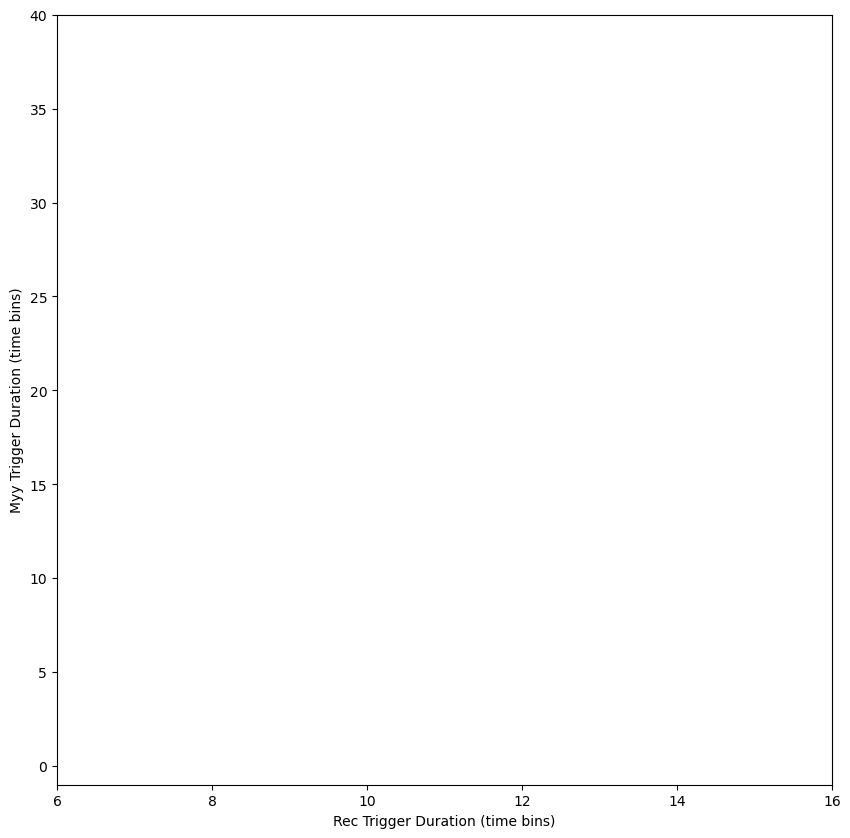

In [4]:
plt.figure(figsize = [10,10])
plt.scatter(Rec_Trigger_Duration, Myy_Trigger_Duration, alpha=0.5)
plt.xlabel('Rec Trigger Duration (time bins)')
plt.ylabel('Myy Trigger Duration (time bins)')
plt.xlim(6,16)
plt.ylim(-1,40)
plt.show()

Text(0, 0.5, 'Myy Trigger Multiplicity / Rec Trigger Multiplicity')

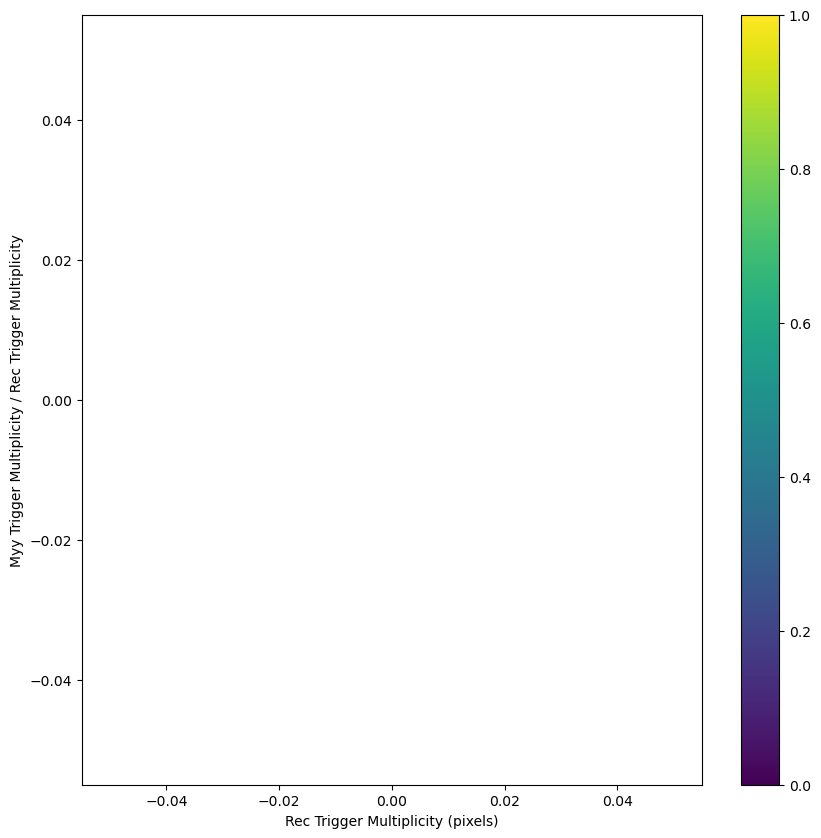

In [5]:

plt.figure(figsize = [10,10])
safe_plot_mask = Rec_Trigger_Multiplicity > 0
plt.scatter(Rec_Trigger_Multiplicity[safe_plot_mask], Myy_Trigger_Multiplicity[safe_plot_mask]/Rec_Trigger_Multiplicity[safe_plot_mask],c = Gen_Rp[safe_plot_mask])
plt.colorbar()
plt.xlabel('Rec Trigger Multiplicity (pixels)')
plt.ylabel('Myy Trigger Multiplicity / Rec Trigger Multiplicity')


ValueError: zero-size array to reduction operation minimum which has no identity

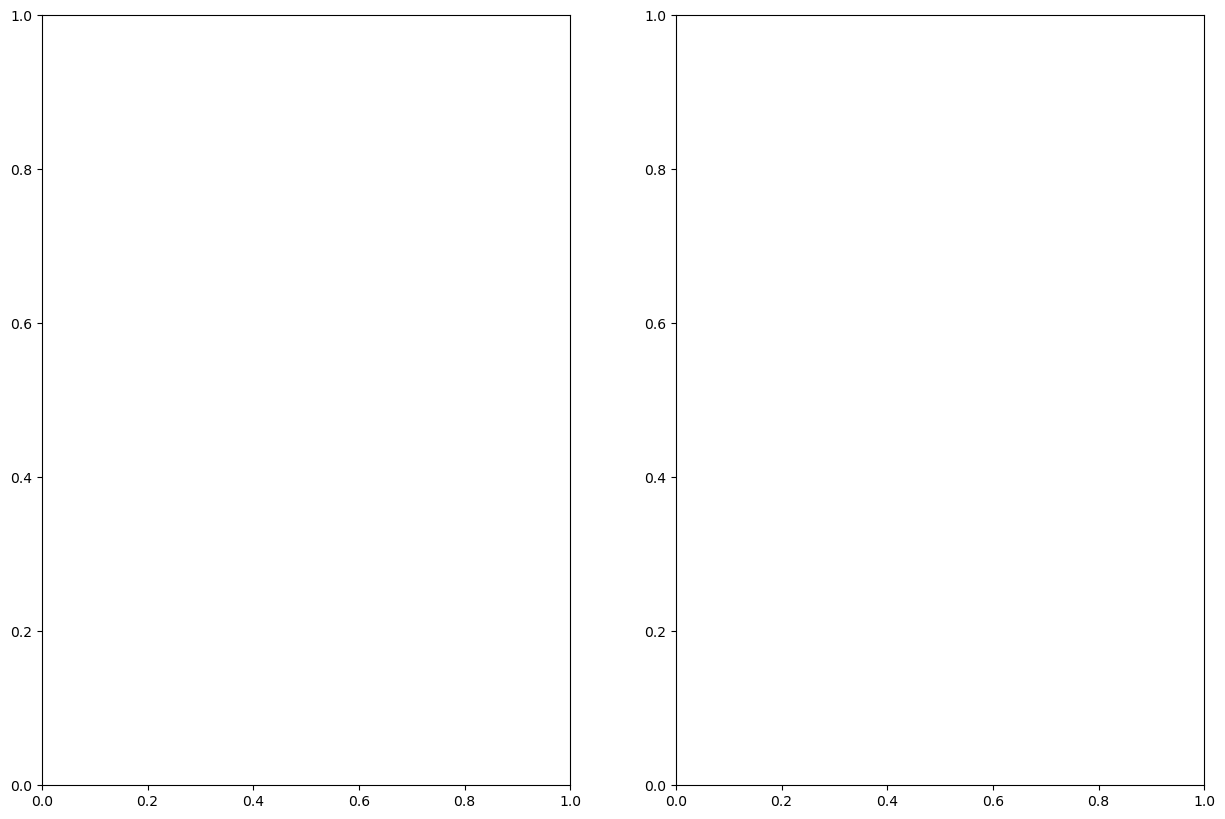

In [6]:
fig,ax = plt.subplots(1,2, figsize = [15,10])
CF_limit = 95
CF_scale = 100-CF_limit

Alpha = Gen_Cherenkov_Fraction-CF_limit
Alpha = np.clip(Alpha,0,CF_scale)/CF_scale

ax[0].scatter(Rec_Trigger_Duration, Rec_Trigger_Multiplicity, c = np.log10(Gen_Rp), alpha=Alpha)
ax[1].scatter(Myy_Trigger_Duration, Myy_Trigger_Multiplicity, c = np.log10(Gen_Rp), alpha=Alpha)
plt.colorbar(ax[1].collections[0], ax=ax, label='log10(Gen_Rp)')

ax[0].set_xlabel('Rec Trigger Duration (time bins)')
ax[0].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[1].set_xlabel('My Trigger Duration (time bins)')
ax[1].set_ylabel('My Trigger Multiplicity (pixles)')

ax[0].set_xlim(0,30)
ax[1].set_xlim(0,30)
plt.show()

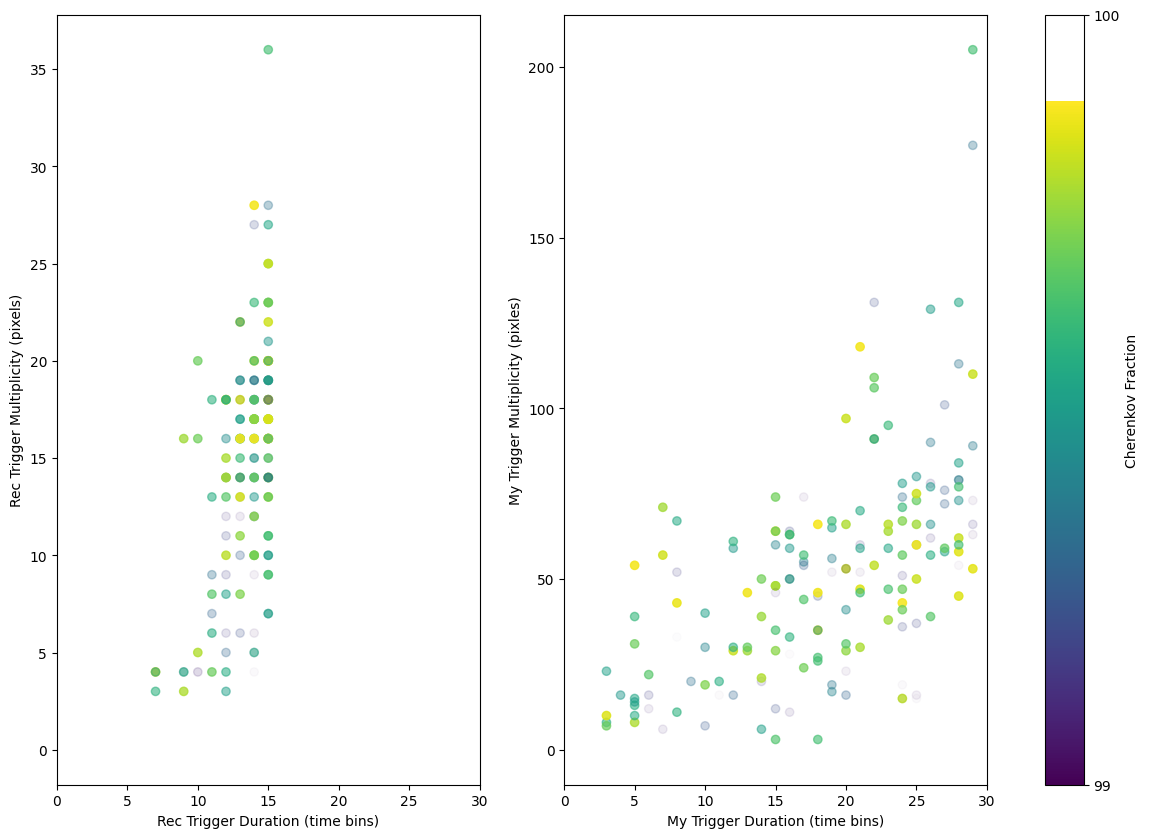

In [ ]:
# fig,ax = plt.subplots(1,2, figsize = [15,10])
# CF_limit = 97
# CF_scale = 100-CF_limit

# Alpha = Gen_Cherenkov_Fraction-CF_limit
# Alpha = np.clip(Alpha,0,CF_scale)/CF_scale

# ax[0].scatter(Rec_Trigger_Duration, Rec_Trigger_Multiplicity, c = Alpha, alpha=Alpha)
# ax[1].scatter(Myy_Trigger_Duration, Myy_Trigger_Multiplicity, c = Alpha, alpha=Alpha)
# plt.colorbar(ax[1].collections[0], ax=ax, label='Cherenkov Fraction')
fig, ax = plt.subplots(1, 2, figsize=[15, 10])
CF_limit = 99
CF_scale = 100 - CF_limit

Alpha = Gen_Cherenkov_Fraction - CF_limit
Alpha = np.clip(Alpha, 0, CF_scale) / CF_scale

sc1 = ax[0].scatter(Rec_Trigger_Duration, Rec_Trigger_Multiplicity, c=Alpha, alpha=Alpha)
sc2 = ax[1].scatter(Myy_Trigger_Duration, Myy_Trigger_Multiplicity, c=Alpha, alpha=Alpha)
cbar = plt.colorbar(sc2, ax=ax, label='Cherenkov Fraction')

cbar.set_ticks([0, 1])
cbar.set_ticklabels([CF_limit, 100])


ax[0].set_xlabel('Rec Trigger Duration (time bins)')
ax[0].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[1].set_xlabel('My Trigger Duration (time bins)')
ax[1].set_ylabel('My Trigger Multiplicity (pixles)')

ax[0].set_xlim(0,30)
ax[1].set_xlim(0,30)
plt.show()

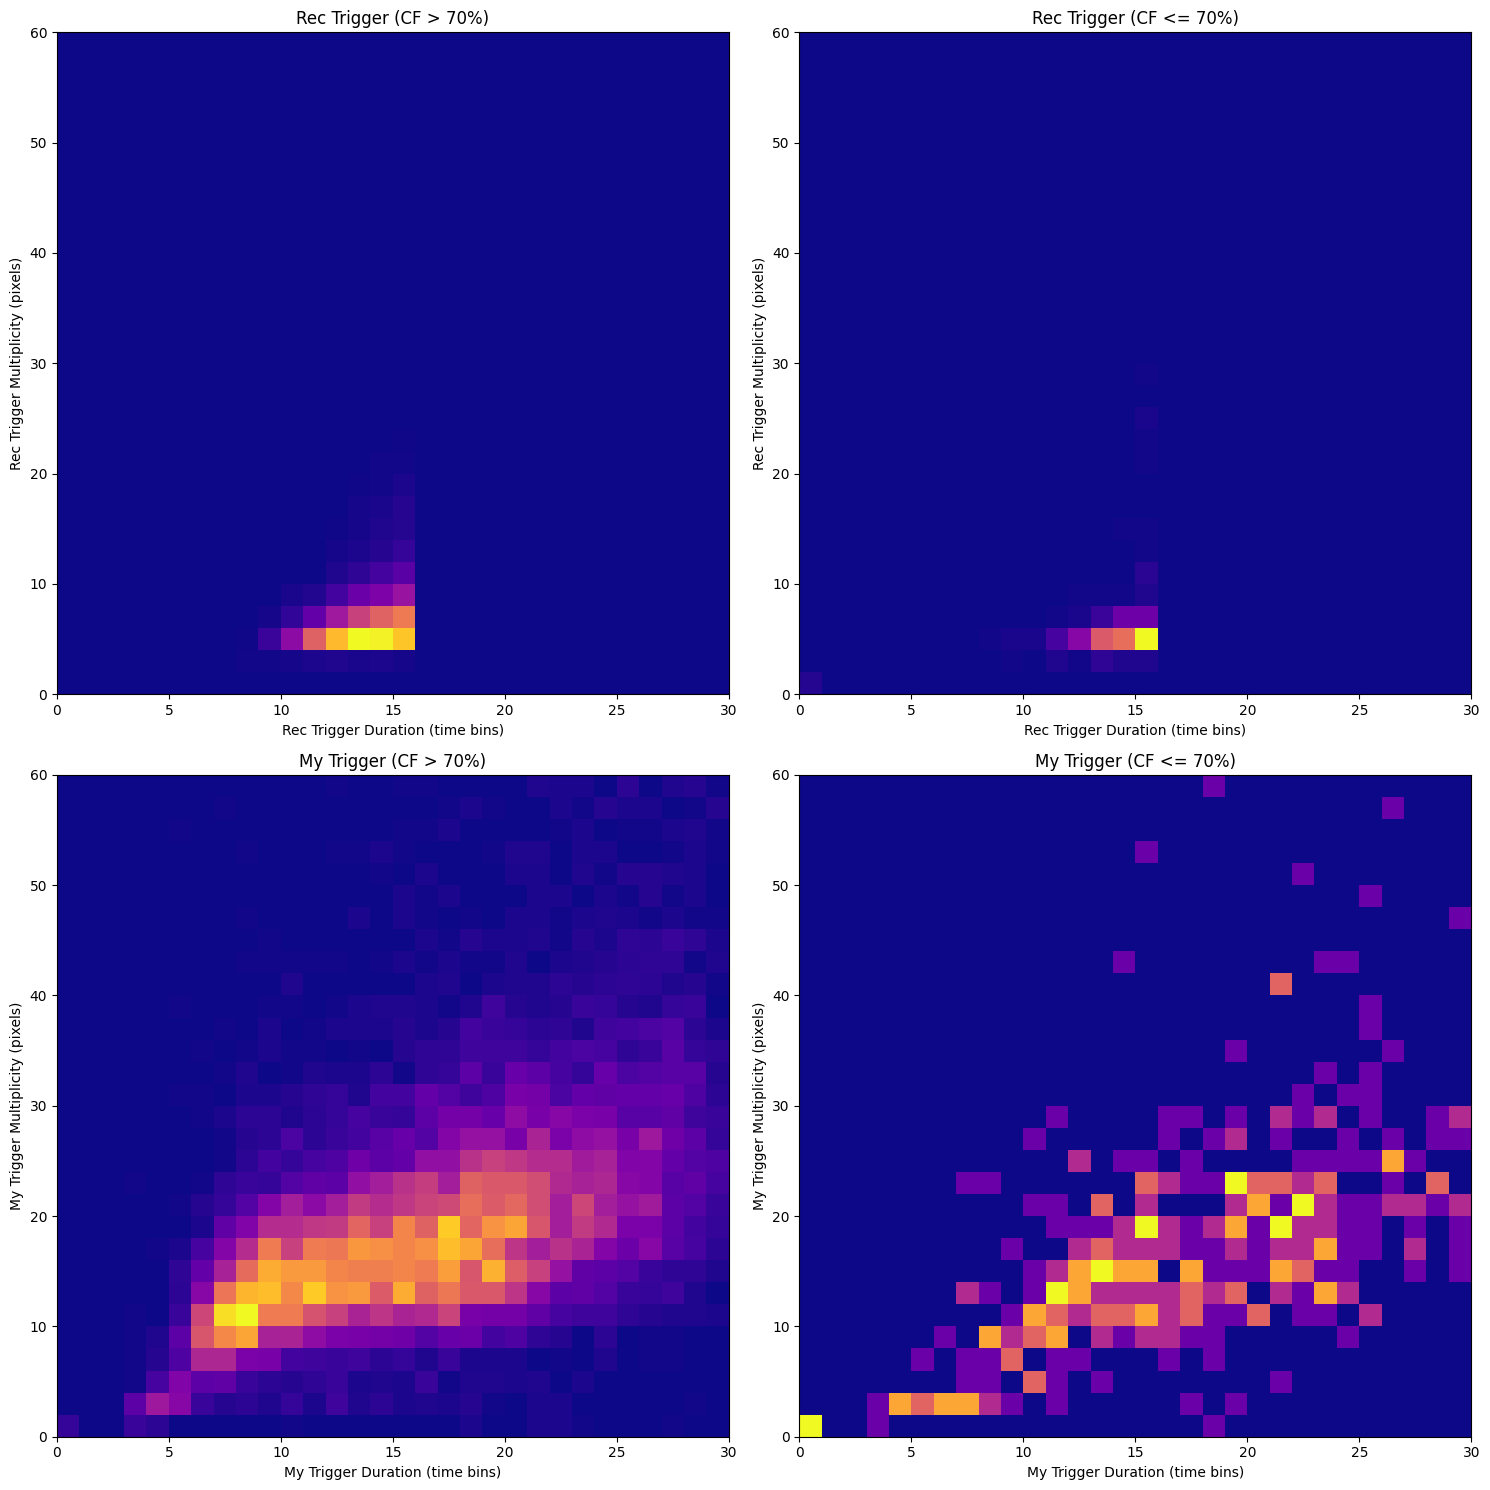

In [ ]:
fig, ax = plt.subplots(2,2, figsize = [15,15])

CF_Cut = 70
Mask = Gen_Cherenkov_Fraction > CF_Cut

C = Gen_Cherenkov_Fraction

ax[0,0].hist2d(Rec_Trigger_Duration[Mask], Rec_Trigger_Multiplicity[Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
# ax[0,0].scatter(Rec_Trigger_Duration[Mask], Rec_Trigger_Multiplicity[Mask], c=Gen_Rp[Mask], cmap='plasma')
ax[0,0].set_xlabel('Rec Trigger Duration (time bins)')
ax[0,0].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[0,0].set_title(f'Rec Trigger (CF > {CF_Cut}%)')
ax[0,0].set_xlim(0,30)
ax[0,0].set_ylim(0,60)

ax[0,1].hist2d(Rec_Trigger_Duration[~Mask], Rec_Trigger_Multiplicity[~Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
# ax[0,1].scatter(Rec_Trigger_Duration[~Mask], Rec_Trigger_Multiplicity[~Mask], c=Gen_Rp[~Mask], cmap='plasma')
ax[0,1].set_xlabel('Rec Trigger Duration (time bins)')
ax[0,1].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[0,1].set_title(f'Rec Trigger (CF <= {CF_Cut}%)')
ax[0,1].set_xlim(0,30)
ax[0,1].set_ylim(0,60)

ax[1,0].hist2d(Myy_Trigger_Duration[Mask], Myy_Trigger_Multiplicity[Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
# ax[1,0].scatter(Myy_Trigger_Duration[Mask], Myy_Trigger_Multiplicity[Mask], c=Gen_Rp[Mask], cmap='plasma')
ax[1,0].set_xlabel('My Trigger Duration (time bins)')
ax[1,0].set_ylabel('My Trigger Multiplicity (pixels)')
ax[1,0].set_title(f'My Trigger (CF > {CF_Cut}%)')
ax[1,0].set_xlim(0,30)
ax[1,0].set_ylim(0,60)

ax[1,1].hist2d(Myy_Trigger_Duration[~Mask], Myy_Trigger_Multiplicity[~Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
# ax[1,1].scatter(Myy_Trigger_Duration[~Mask], Myy_Trigger_Multiplicity[~Mask], c=Gen_Rp[~Mask], cmap='plasma')
ax[1,1].set_xlabel('My Trigger Duration (time bins)')
ax[1,1].set_ylabel('My Trigger Multiplicity (pixels)')
ax[1,1].set_title(f'My Trigger (CF <= {CF_Cut}%)')
ax[1,1].set_xlim(0,30)
ax[1,1].set_ylim(0,60)
plt.tight_layout()
plt.show()

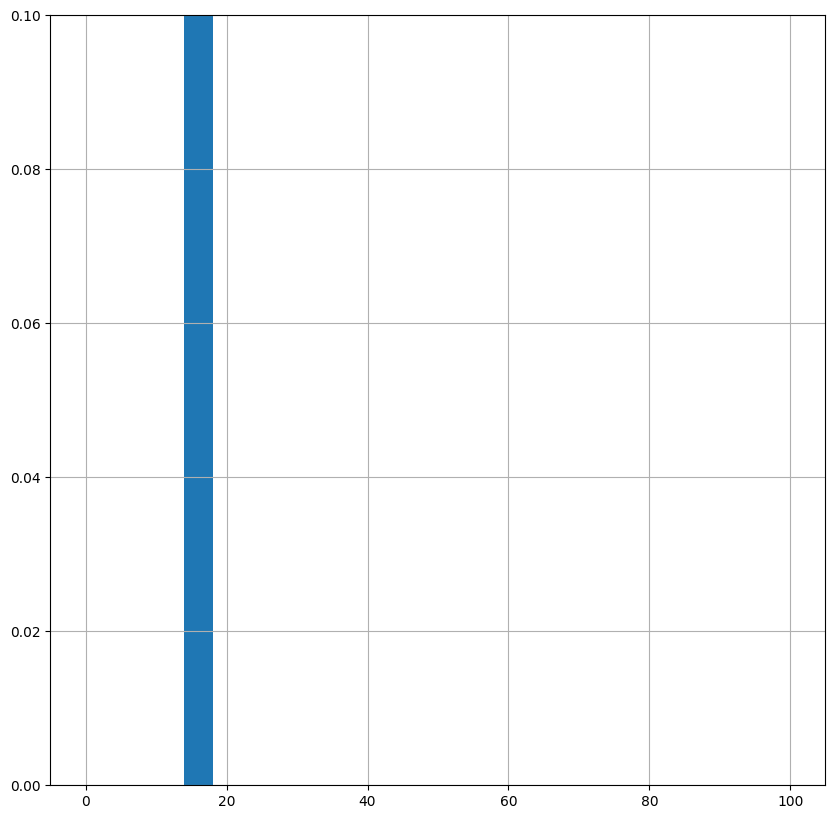

In [ ]:
plt.figure(figsize = [10,10])
plt.hist(Gen_Cherenkov_Fraction, bins=50, range=[0,100],density=True)
plt.ylim(0,0.1)
plt.grid()

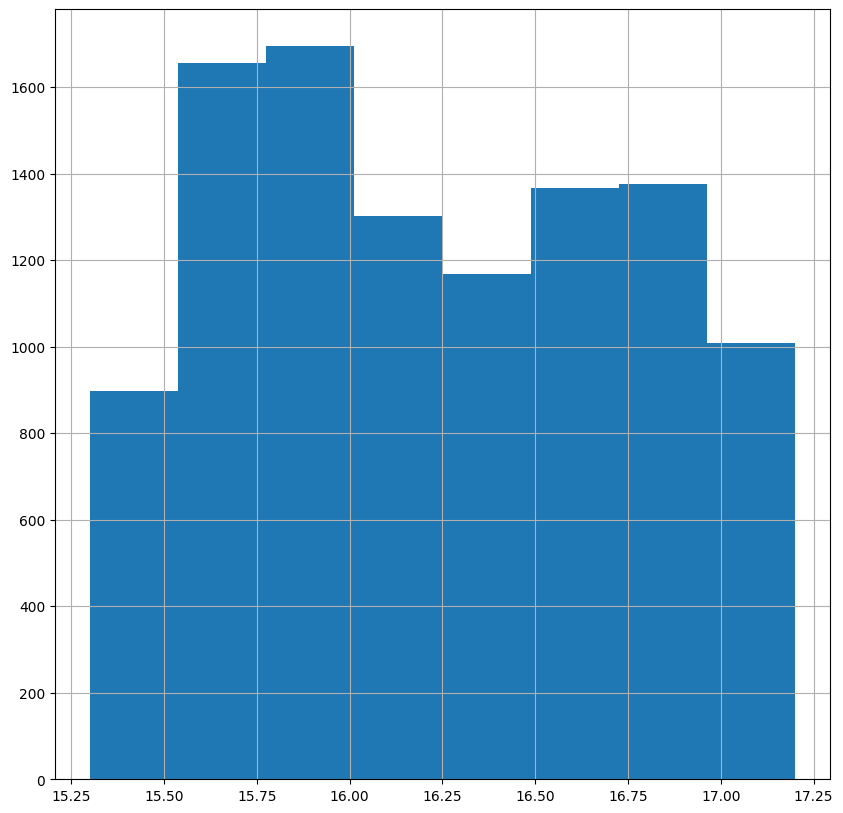

In [ ]:
plt.figure(figsize = [10,10])
plt.hist(Gen_LogE, bins=8)
# plt.ylim(0,0.1)
plt.grid()

6485


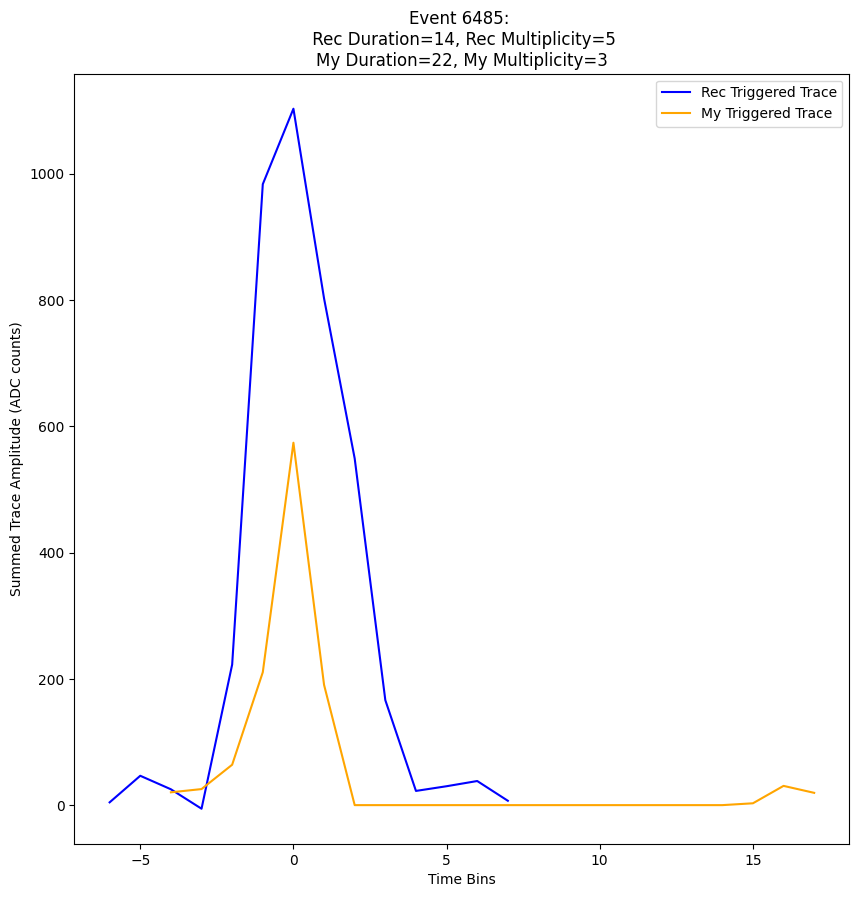

In [ ]:
N = np.random.randint(0, len(Rec_Trigger_Traces))
print(N)

plt.figure(figsize = [10,10])

Rec_Trigger_Trace = Rec_Trigger_Traces[N]
Myy_Trigger_Trace = Myy_Trigger_Traces[N]

# Find the index of the maximum value
max_index_Rec = np.argmax(Rec_Trigger_Trace)
max_index_Myy = np.argmax(Myy_Trigger_Trace)

# Center the x values
x_values_Rec = np.arange(len(Rec_Trigger_Trace)) - max_index_Rec
x_values_Myy = np.arange(len(Myy_Trigger_Trace)) - max_index_Myy

plt.plot(x_values_Rec, Rec_Trigger_Trace, label='Rec Triggered Trace', color='blue')
plt.plot(x_values_Myy, Myy_Trigger_Trace, label='My Triggered Trace', color='orange')

plt.xlabel('Time Bins')
plt.ylabel('Summed Trace Amplitude (ADC counts)')
plt.title(f'Event {N}: \n Rec Duration={Rec_Trigger_Duration[N]}, Rec Multiplicity={Rec_Trigger_Multiplicity[N]}\nMy Duration={Myy_Trigger_Duration[N]}, My Multiplicity={Myy_Trigger_Multiplicity[N]}')
# plt.yscale('log')
plt.legend()

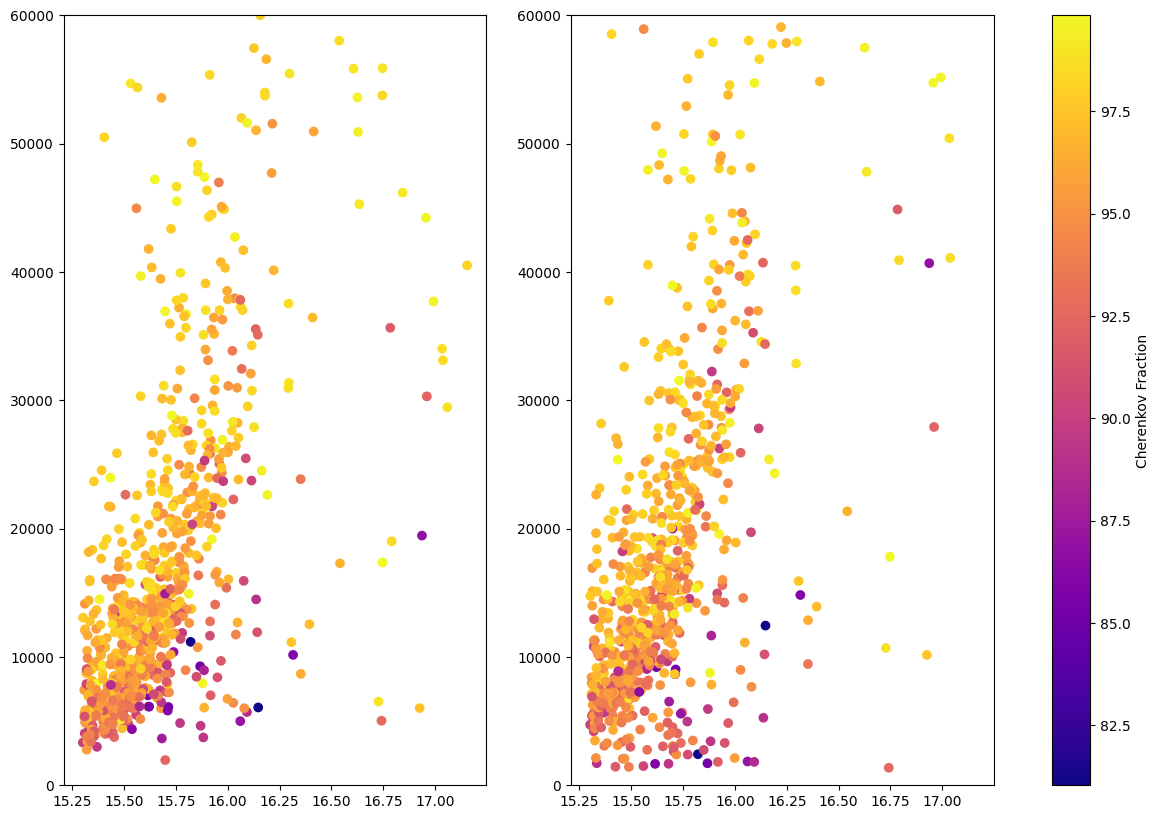

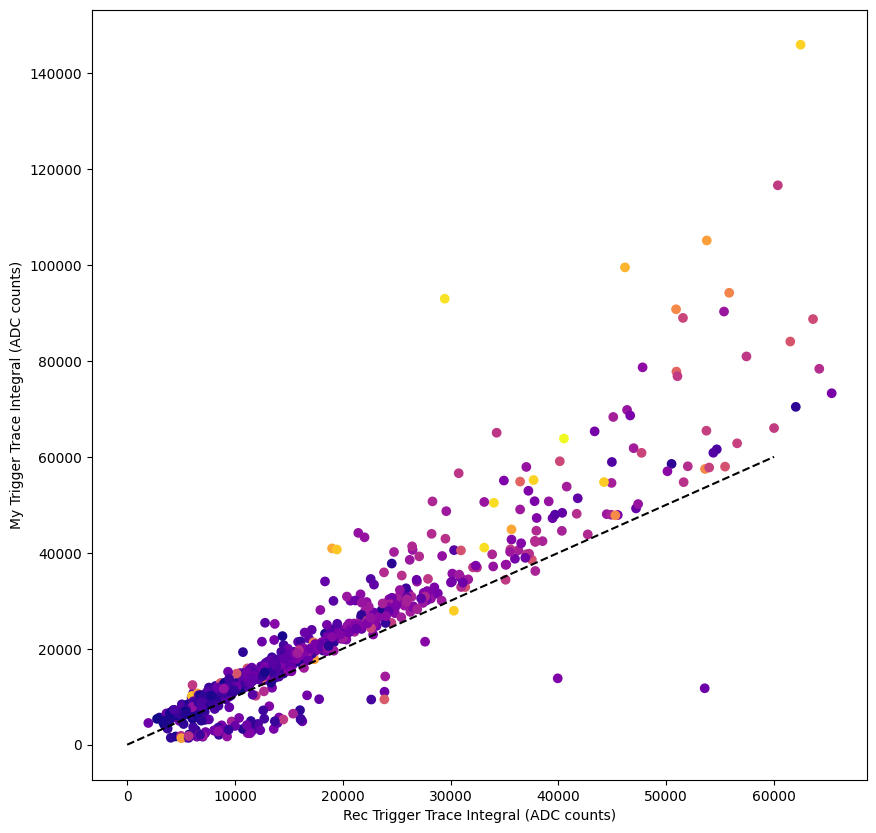

In [ ]:
X = [np.sum(Rec_Trigger_Trace) for Rec_Trigger_Trace in Rec_Trigger_Traces]
Y = [np.sum(Myy_Trigger_Trace) for Myy_Trigger_Trace in Myy_Trigger_Traces]

Energy = Gen_LogE
cut = (Gen_Rp < 750) & (Gen_Cherenkov_Fraction > 80)

X = np.array(X)[cut]
Y = np.array(Y)[cut]
Energy = np.array(Energy)[cut]

fig, ax = plt.subplots(1,2, figsize = [15,10])



ax[0].scatter(Energy, X, c= Gen_Cherenkov_Fraction[cut], cmap='plasma')
ax[1].scatter(Energy, Y, c= Gen_Cherenkov_Fraction[cut], cmap='plasma')

plt.colorbar(ax[1].collections[0], ax=ax, label='Cherenkov Fraction')

ax[0].set_ylim(0,60000)
ax[1].set_ylim(0,60000)


plt.figure(figsize = [10,10])
plt.scatter(X,Y, c= Energy, cmap='plasma')
plt.xlabel('Rec Trigger Trace Integral (ADC counts)')
plt.ylabel('My Trigger Trace Integral (ADC counts)')

plt.plot([0, 60000], [0, 60000], color='black', linestyle='--')



In [ ]:
with open(all_files[0], 'rb') as f:
    batch_data = pickle.load(f)


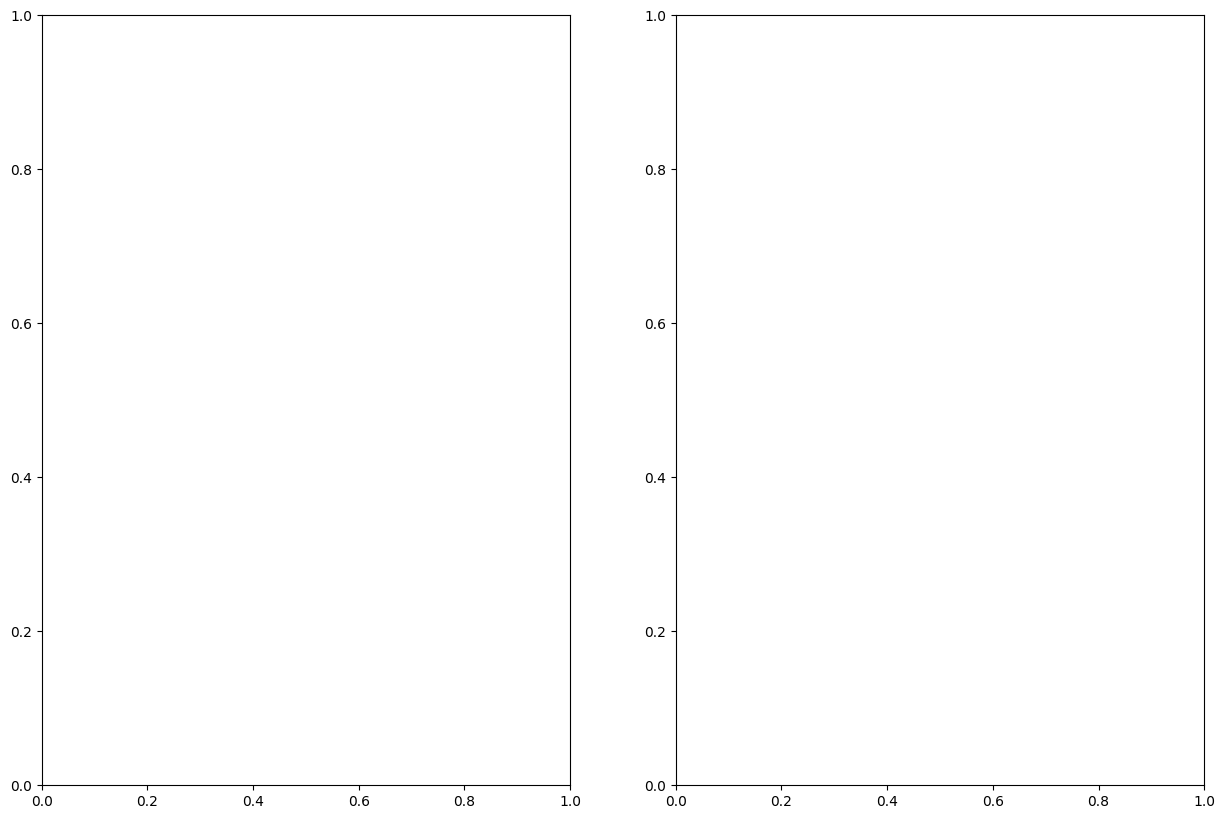

In [ ]:
N = np.random.randint(0, len(batch_data))
Event = batch_data[N]

fig, ax = plt.subplots(1,2,figsize = [15,10])


